# HR WerkenBij Recommender
This notebook is an initial build of the HR webpage recommender. It builds upon exisiting packages, such as NLTK and Spacy and was mainly produced as trial and "getting back into Python" for Yorran. Thus, be aware of the quality of code. I now know where I stand and will do some catching up during the christmas holiday! 

The URLS are aqcuired from Google Analytics, as the Chromium plugin will constantly need to be updated and does not provide Notebook support (anymore). Thus, using a list of urls, the scraper works with beautifulSoup. The notebook then continues to do some preprocessing before making a cosine similairity matrix! It then visualizes the similairity using the vacancy Indexnumbers and eventuelly has a small minimalstic function that you can use to insert a vacancy and get the most similair work in return. 

As I wasn't aware of the final deliverable for the website; I did not include a final nested-list or dataframe, as this is highly dependend on the requirements :/

In general, it isn't much, but it is honest work! :D

In [ ]:
# Imports
import bs4 as bs
import urllib.request
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import networkx as nx

# NLTK
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords


# Viz 
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

# Spacy 
import nl_core_news_sm

In [129]:
# Scrape demo content using url list without the company name in it!

df_ga = pd.read_csv('urls_recommender_dec3.csv', sep = ';')
df_ga['Page'] = df_ga['Page'].str.lower()
search ="/items/nl-nl/vacatures/"
bool_series = df_ga["Page"].str.startswith(search, na = False) 
df_ga = df_ga[bool_series]
df_ga['Cat'] = df_ga['Page'].str.split('/').str[4]


# Code below can be used to only get specifiek fields.
#vakgebieden = ['data-en-analytics' , 'it', 'ict', 'traineeship']
#booly = df_ga['Cat'].isin(vakgebieden)
#df_ga = df_ga[booly]

df_ga['Url'] = "https://www.werkenbijanwb.nl"+ df_ga["Page"] 
list_url = df_ga['Url'].tolist()

ListNummer = 0
ListTotaal = []


for x in list_url:
    try:
        source = urllib.request.urlopen(x).read()
        soup = bs.BeautifulSoup(source,'lxml')
        title = soup.title.string
        ListNaam = "Vacature" + str(ListNummer)
        ListNummer = ListNummer + 1
        #print(title, "boven loop")
        for div in soup.find_all('span', class_ = 'extText'):
            Listy = []
            Listy.append(ListNaam)
            Listy.append(str(title))
            #print(title, "Onderloop")
            Listy.append(div.text)
            #print('Scraping succesfull')
    except:
        print(x, 'Scraping failed - URL does not contain a scraoable result or page does not exist.')
        
    ListTotaal.append(Listy)

# After scrape make DF
df_tekst = pd.DataFrame(ListTotaal, columns =['Nummer', 'Vacture', 'Tekst'])
df_tekst = df_tekst.drop_duplicates(subset = 'Nummer', keep = 'first')
df_tekst = df_tekst.drop_duplicates(subset = 'Vacture', keep = 'first')

https://www.werkenbijanwb.nl/items/nl-nl/vacatures/hulpverlening/scouts-contactonderzoek-corona-den-haag Scraping failed - URL does not contain a scraoable result or page does not exist.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/marketing-en-communicatie/allround-digital-marketeer--s-gravenhage Scraping failed - URL does not contain a scraoable result or page does not exist.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/marketing-en-communicatie/product-manager-anwb-rijopleiding--eindhoven Scraping failed - URL does not contain a scraoable result or page does not exist.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/retail/replenisher-harderwijk Scraping failed - URL does not contain a scraoable result or page does not exist.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/retail/merchandise-planner-harderwijk Scraping failed - URL does not contain a scraoable result or page does not exist.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/data-en-analytics/manage

KeyError: Index(['Vacature'], dtype='object')

## Preprocess data

After the initial scraping, we can continue with the preprocessing of the data.

In [133]:
# Strip all sentences and make them lowercase.
def sentence(x):
    tekst = x
    zinnen = tekst.replace("[^a-zA-Z]", " ").split(". ")
    #zinlijst.append(zinnen.lower().split(" "))
    return zinnen

df_tekst['Los'] = df_tekst['Tekst'].str.lower().str.replace('\W', ' ').apply(sentence)

## Stopwords imports
stopwords = nltk.corpus.stopwords.words('dutch')
stopwords.extend(['anwb', 'demo2', 'jij', 'heb', 'als'] )

#Stopword removal
df_tekst['Stopaf'] = df_tekst['Los'].apply(lambda x: ' '.join([word for word in x[0].split() if word not in (stopwords)]))

# However, for the next sectopn, it needs to be in a nested list, or single list per cell. Hence, we add the content of every
# cell to list with a quick function.
def tolistor(x):
    listy = []
    listy.append(x)
    return listy

df_tekst['Stopaf'] = df_tekst['Stopaf'].apply(tolistor)

# Now we can safely continue
# Stemming

from nltk.stem.snowball import SnowballStemmer

# Demo the technique
# stemmer.stem('medewerkers')

# Import Dutch stemmer.
stemmer = SnowballStemmer("dutch")

df_tekst['Stemmed'] = df_tekst['Stopaf'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

# Extract text from list and insert it back into the DF with a function. 
def selector(x):
    return x[0]

df_tekst['Stemmed'] = df_tekst['Stemmed'].apply(selector)


# lemmatization English!
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_tekst['Lemma'] = df_tekst['Stemmed'].apply(lemmatize_text)

# Get them out of the list
def selector(x):
    s = ' '.join(x)
    return s

df_tekst['processed'] = df_tekst['Lemma'].apply(selector)

# Working towards the most important keywords using Spacy zinsontleding. This way we only select NOUNS, as these
# have proven to contain the most valuable information.

nlp = nl_core_news_sm.load()

def get_POS(x):
    list_words = []
    doc = nlp(str(x))
    list_elements = [(w.text, w.pos_) for w in doc]
    for x in list_elements:
        if x[1] == 'NOUN':
            list_words.append(x[0])
    return list_words

# Demo
# get_POS('hoe is mijn naam is naam is naam')

df_tekst['KeyNouns'] = df_tekst['processed'].apply(get_POS)

def selector(x):
    s = ' '.join(x)
    return s

df_tekst['KeyNouns'] = df_tekst['KeyNouns'].apply(selector)

# Display df
df_tekst.head()

<ipython-input-133-f762af5b51cc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tekst['Los'] = df_tekst['Tekst'].str.lower().str.replace('\W', ' ').apply(sentence)
<ipython-input-133-f762af5b51cc>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tekst['Stopaf'] = df_tekst['Los'].apply(lambda x: ' '.join([word for word in x[0].split() if word not in (stopwords)]))
<ipython-input-133-f762af5b51cc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Nummer,Vacture,Tekst,Los,Stopaf,Stemmed,Lemma,processed,KeyNouns
0,Vacature47,Vacatures - Internal Auditor,Meer informatie over de inhoud van de functie ...,[meer informatie over de inhoud van de functie...,[informatie inhoud functie vraag miranda hesse...,informatie inhoud functie vraag miranda hessel...,"[informatie, inhoud, functie, vraag, miranda, ...",informatie inhoud functie vraag miranda hessel...,informatie inhoud functie vraag mhesselink pro...
1,Vacature0,Vacatures - Product Owner – Wegenwacht Sales Team,Jouw focus ligt op de conversie gerelateerde d...,[jouw focus ligt op de conversie gerelateerde ...,[jouw focus ligt conversie gerelateerde dienst...,jouw focus ligt conversie gerelateerde dienste...,"[jouw, focus, ligt, conversie, gerelateerde, d...",jouw focus ligt conversie gerelateerde dienste...,focus conversie diensten conversie conversies ...
2,Vacature1,Vacatures - Contentspecialist,Meer informatie over de inhoud van de functie ...,[meer informatie over de inhoud van de functie...,[informatie inhoud functie vraag marco berends...,informatie inhoud functie vraag marco berends ...,"[informatie, inhoud, functie, vraag, marco, be...",informatie inhoud functie vraag marco berends ...,informatie inhoud functie vraag marketing comm...
5,Vacature2,Vacatures - Marketing Data Analist,Als marketing data analist ben je continu bezi...,[als marketing data analist ben je continu bez...,[marketing data analist continu bezig analyser...,marketing data analist continu bezig analysere...,"[marketing, data, analist, continu, bezig, ana...",marketing data analist continu bezig analysere...,marketing analist klant organisatie beslissing...
7,Vacature3,Vacatures - Technisch Docent,Als technisch docent ga je vanuit je expertise...,[als technisch docent ga je vanuit je expertis...,[technisch docent ga vanuit expertise slag opl...,technisch docent ga vanuit expertise slag ople...,"[technisch, docent, ga, vanuit, expertise, sla...",technisch docent ga vanuit expertise slag ople...,docent slag wegenwacht vorm land e learning tr...


## Cosine similairity
Let Sklearn do the magic! 

In [136]:
# Do the cosine calculations for all available ids. 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_tekst['KeyNouns'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [137]:
# Restructure the index of the df for further visualisation. 
df_tekst = df_tekst.reset_index(drop = True)
df_tekst['Nummer'] = df_tekst.index 
df_tekst.drop('Nummer', axis = 1, inplace = True)
df_cos = pd.DataFrame(cosine_sim)

## Plotting! 

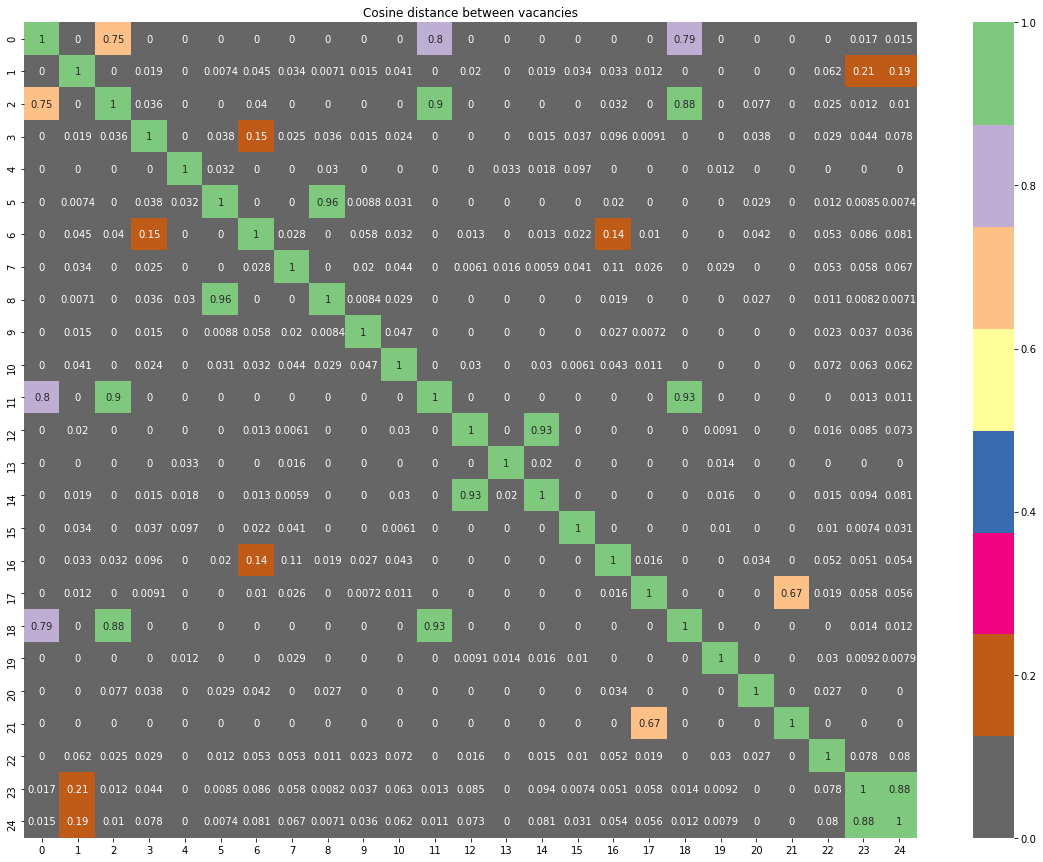

In [138]:
# Plotting the vacancies. 
import matplotlib as plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,15))
plt.title("Cosine distance between vacancies")
sns.heatmap(df_cos, cmap="Accent_r", annot=True, )

#YlGnBu

## Getting to the best possible match per ID

In [140]:
# Lets create a quick df that we can use later to combine with our predictions. 
df_title = df_tekst['Vacture']
df_title = pd.DataFrame(df_title)

In [141]:
merged =  df_cos.merge(df_title, left_index=True, right_index= True)

In [142]:
def get_closest(df, col, topx):
    ''' This function allows you get the top x number of similair job vacancies based on cosine.
        Insert the DF name with cosines distances;
        the index of the job;
        the top (n).
        Be aware that a very high similairy may not be good, as this can be the same vacancy but in a different catagory.
    '''
    print('De top ', topx, ' aansluitende vacatures voor: ', df_tekst['Vacture'][col].split('-', 1)[-1].lstrip())
    new = pd.DataFrame(df[col].nlargest(topx + 3)).merge(df_title, left_index = True, right_index = True)
    title = df_tekst['Vacture'][col].split('-', 1)[-1].lstrip()
    new[str(title)] = new[col]
    new = new[['Vacture', str(title)]].drop_duplicates()
    return new.sort_values(by=[str(title)], ascending = False).head(topx)
    if topx < len(df):
        print("Could not show", topx, 'examples, as there is not such an amount of data!')

In [161]:
# put the top 5 in a column for every vacancy.
# complete_list = []
# for job in df_tekst['Vacture']:
#     idx = df_tekst.index[df_tekst['Vacture'] == str(job)]
#     new = pd.DataFrame(df_cos[idx[0]].nlargest(5)).merge(df_title, left_index = True, right_index = True)
#     #top_list = new['vacture'].tolist()


## Insert and enjoy!

In [103]:
# The function below gives you the top x for every vacancy!
topx = None
while topx is None:
    try:
        topx = int(input("Enter the top x you want: "))
    except ValueError:
        print('Enter an integer value! Foei')
vac = None
while vac is None:
    try:
        vac = int(input("Enter the Vacature ID: "))
    except ValueError:
        print('Enter a vacature ID from the list above!')
        

        
get_closest(df_cos, vac, topx)

Enter the top x you want: 5
Enter the Vacature ID: 17
De top  5  aansluitende vacatures voor:  iOS Developer


,Vacture,iOS Developer
17,Vacatures - iOS Developer,1.000000
22,Vacatures - Android Developer,0.655738
28,Vacatures - UX Designer Hulpverlening sales,0.057964
30,Vacatures - UX Designer Generieke Klantinterfa...,0.054687
7,Vacatures - Manager IT Medior Wegenwacht,0.024121
